In [45]:
pip install mplsoccer

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch


# Define the path to your data files in Google Drive
data_path = '/content/drive/My Drive/Football_Data/'

# Load the event data
events = pd.read_csv(data_path + 'Sample_Game_1_RawEventsData.csv')

# Load the tracking data for both teams
tracking_home = pd.read_csv(data_path + 'Sample_Game_1_RawTrackingData_Home_Team.csv')
tracking_away = pd.read_csv(data_path + 'Sample_Game_1_RawTrackingData_Away_Team.csv')

# You can now proceed with your analysis
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47


In [48]:
tracking_home.tail()

,Period,Frame,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,...,Home_10_x,Home_11_y.1,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,Ball_x,Ball_y
145001,2,145002,5800.08,0.90614,0.45355,NaN,NaN,0.34157,0.64598,0.31228,...,NaN,NaN,0.30044,0.68311,0.33644,0.65390,0.34157,0.64598,NaN,NaN
145002,2,145003,5800.12,0.90550,0.45355,NaN,NaN,0.34127,0.64583,0.31230,...,NaN,NaN,0.30044,0.68311,0.33656,0.65398,0.34127,0.64583,NaN,NaN
145003,2,145004,5800.16,0.90492,0.45355,NaN,NaN,0.34089,0.64569,0.31214,...,NaN,NaN,0.30044,0.68311,0.33637,0.65366,0.34089,0.64569,NaN,NaN
145004,2,145005,5800.20,0.90456,0.45356,NaN,NaN,0.34056,0.64552,0.31171,...,NaN,NaN,0.30044,0.68311,0.33615,0.65317,0.34056,0.64552,NaN,NaN
145005,2,145006,5800.24,0.90456,0.45356,NaN,NaN,0.33996,0.64544,0.31122,...,NaN,NaN,0.30044,0.68311,0.33563,0.65166,0.33996,0.64544,NaN,NaN


In [49]:
tracking_away.head()

,Period,Frame,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,...,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Away_27_x,Away_27_y,Away_28_x,Away_15_y.1,Ball_x,Ball_y
0,1,1,0.04,0.90509,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
1,1,2,0.08,0.90494,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
2,1,3,0.12,0.90434,0.47463,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
3,1,4,0.16,0.90377,0.47463,0.58351,0.20868,0.67640,0.46762,0.67279,...,0.37756,0.27473,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
4,1,5,0.20,0.90324,0.47464,0.58291,0.21039,0.67599,0.46769,0.67253,...,0.37663,0.27543,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570


	•	Home always attacks left → right (x increasing).
	•	Away always attacks right → left (x decreasing).

That way you don’t need to normalize pass-by-pass later. This is the cleanest approach for scalability.

⸻

⚙️ Transformation Rules
	•	Events dataset
	•	If Period == 2:
	•	For Home team → x = 1 - x, y = 1 - y.
	•	For Away team → same flip (so that both teams get reoriented consistently).
	•	Tracking datasets (home + away)
	•	For every frame in Period 2 → flip all (x, y) coordinates.

⸻

📝 Code to Standardize Datasets

In [50]:
def flip_coords(x, y):
    """Flip coordinates horizontally + vertically."""
    return 1 - x, 1 - y

# --- 1. Events Dataset ---
def normalize_events(events):
    events = events.copy()
    for idx, row in events.iterrows():
        if row['Period'] == 2:  # 2nd half
            # Flip start coords
            events.at[idx, 'Start X'], events.at[idx, 'Start Y'] = flip_coords(row['Start X'], row['Start Y'])
            # Flip end coords
            events.at[idx, 'End X'], events.at[idx, 'End Y'] = flip_coords(row['End X'], row['End Y'])
    return events

# --- 2. Tracking Dataset ---
def normalize_tracking(tracking):
    tracking = tracking.copy()
    for idx, row in tracking.iterrows():
        if row['Period'] == 2:
            for col in tracking.columns:
                if '_x' in col:
                    y_col = col.replace('_x', '_y')
                    # Check if the corresponding y column exists before accessing
                    if y_col in tracking.columns:
                        tracking.at[idx, col], tracking.at[idx, y_col] = flip_coords(
                            row[col], row[y_col]
                        )
    return tracking

# Apply transformations
events_norm = normalize_events(events)
tracking_home_norm = normalize_tracking(tracking_home)
tracking_away_norm = normalize_tracking(tracking_away)

📂 Step 1: Initialize Structure

Analyzing pass from Player15 to Player19 at frame 45
Passer Player15 not found in tracking data for frame 45. Cannot analyze pass.


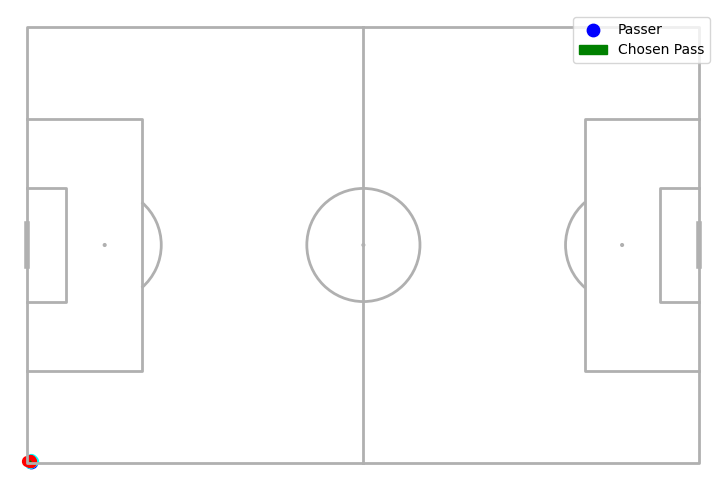

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Example: pick one pass event
pass_event = events_norm.iloc[3]   # row 3 = a PASS in your sample printout, with Start Frame 45
frame_id = pass_event['Start Frame']
team = pass_event['Team']
passer_id = pass_event['From']
receiver_id = pass_event['To']

print(f"Analyzing pass from {passer_id} to {receiver_id} at frame {frame_id}")

# --- Step 1: Extract player positions at this frame ---
if team == "Home":
    teammates_tracking = tracking_home_norm[tracking_home_norm['Frame'] == frame_id]
    opponents_tracking = tracking_away_norm[tracking_away_norm['Frame'] == frame_id]
    team_prefix = "Home_"
    opponent_prefix = "Away_"
else:
    teammates_tracking = tracking_away_norm[tracking_away_norm['Frame'] == frame_id]
    opponents_tracking = tracking_home_norm[tracking_home_norm['Frame'] == frame_id]
    team_prefix = "Away_"
    opponent_prefix = "Home_"


# Flatten row into dictionary {player_id: (x, y)}
teammate_positions = {}
for col in teammates_tracking.columns:
    if '_x' in col:
        player_id = col.split('_')[1]
        x_col = col
        y_col = col.replace('_x', '_y')
        if y_col in teammates_tracking.columns: # Check if y column exists
            teammate_positions[player_id] = (teammates_tracking.iloc[0][x_col], teammates_tracking.iloc[0][y_col])

opponent_positions = []
for col in opponents_tracking.columns:
    if '_x' in col:
        x_col = col
        y_col = col.replace('_x', '_y')
        if y_col in opponents_tracking.columns: # Check if y column exists
            opponent_positions.append((opponents_tracking.iloc[0][x_col], opponents_tracking.iloc[0][y_col]))


# Remove NaNs (players not on pitch)
teammate_positions = {pid: (x, y) for pid, (x, y) in teammate_positions.items() if not np.isnan(x)}
opponent_positions = [(x, y) for (x, y) in opponent_positions if not np.isnan(x)]

# --- Step 2: Identify passer coordinates ---
# Find the passer's position in the teammate_positions dictionary
passer_position = teammate_positions.get(passer_id.replace(team_prefix, ''))
if passer_position is None:
    print(f"Passer {passer_id} not found in tracking data for frame {frame_id}. Cannot analyze pass.")
    # Handle the case where the passer is not found, perhaps skip this event or use event data coordinates
    start_x, start_y = pass_event['Start X'], pass_event['Start Y'] # Use event data coordinates if tracking is missing
else:
    start_x, start_y = passer_position


# --- Step 3: Candidate passes (to all teammates except passer) ---
candidates = {pid: (x, y) for pid, (x, y) in teammate_positions.items() if f"{team}_{pid}" != passer_id}

# --- Step 4: Feasibility check: is pass blocked? ---
def point_line_distance(px, py, x1, y1, x2, y2):
    """Shortest distance from point (px,py) to line segment (x1,y1)-(x2,y2)."""
    A = px - x1
    B = py - y1
    C = x2 - x1
    D = y2 - y1

    dot = A*C + B*D
    len_sq = C*C + D*D
    param = dot / len_sq if len_sq != 0 else -1

    if param < 0:
        xx, yy = x1, y1
    elif param > 1:
        xx, yy = x2, y2
    else:
        xx, yy = x1 + param*C, y1 + param*D

    dx = px - xx
    dy = py - yy
    return np.sqrt(dx*dx + dy*dy)

feasible_passes = {}
for pid, (end_x, end_y) in candidates.items():
    blocked = False
    for (dx, dy) in opponent_positions:
        # Ensure opponent coordinates are not NaN before calculating distance
        if not np.isnan(dx) and not np.isnan(dy):
            if point_line_distance(dx, dy, start_x, start_y, end_x, end_y) < 0.02:  # threshold (scaled to pitch coords 0–1)
                blocked = True
                break
    if not blocked:
        feasible_passes[pid] = (end_x, end_y)

# --- Step 5: Visualization ---
pitch = Pitch(pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(figsize=(8, 5))

# Plot passer
ax.scatter(start_x, start_y, c='blue', s=80, label="Passer")

# Plot teammates
for pid, (x, y) in teammate_positions.items():
    ax.scatter(x, y, c='cyan', s=50)

# Plot defenders
for (dx, dy) in opponent_positions:
    ax.scatter(dx, dy, c='red', s=50)

# Actual chosen pass
# Ensure end coordinates from pass_event are not NaN before plotting
end_x_actual, end_y_actual = pass_event['End X'], pass_event['End Y']
if not np.isnan(end_x_actual) and not np.isnan(end_y_actual):
    ax.arrow(start_x, start_y,
             end_x_actual - start_x, end_y_actual - start_y,
             width=0.002, head_width=0.02, color='green', label="Chosen Pass")
else:
    print("Actual pass end coordinates are NaN. Cannot plot the actual pass.")


# Feasible alternative passes
for pid, (end_x, end_y) in feasible_passes.items():
    ax.arrow(start_x, start_y, end_x-start_x, end_y-start_y,
             width=0.001, head_width=0.015, color='orange', linestyle='--')

ax.legend()
plt.show()

🧩 Step 2: Fill with Direct Event Data

From events you can directly map:
	•	player_from, player_to
	•	start_x, start_y, end_x, end_y
	•	timestamp, frame_id
	•	team (Home/Away)

And generate pass_id:

In [52]:
home_counter, away_counter = 1, 1

def generate_pass_id(team):
    global home_counter, away_counter
    if team == "Home":
        pid = f"H{home_counter}"
        home_counter += 1
    else:
        pid = f"A{away_counter}"
        away_counter += 1
    return pid

🧮 Step 3: Derived Metrics (functions)
	1.	Distance

In [53]:
def pass_distance(x1, y1, x2, y2):
    return ((x2-x1)**2 + (y2-y1)**2) ** 0.5

#	2.	Direction (relative to goal axis)

In [54]:
import math


def pass_angle(x1, y1, x2, y2):
    dx, dy = x2 - x1, y2 - y1
    return np.degrees(np.arctan2(dy, dx))

def pass_direction(x1, y1, x2, y2):
    """Categorize pass as Forward, Backward, Sideways."""
    angle = pass_angle(x1, y1, x2, y2)
    if -45 <= angle <= 45:
        return "Forward"
    elif angle >= 135 or angle <= -135:
        return "Backward"
    else:
        return "Sideways"

3.	Possession Order

	•	Reset to 1 when possession changes.

In [55]:
def pass_possession_index(events):
    """
    Count passes only within a possession.
    Resets when possession changes (Team switches).
    """
    indices = []
    current_team = None
    counter = 0

    for _, row in events.iterrows():
        if row['Team'] != current_team:
            current_team = row['Team']
            counter = 0
        if row['Type'] == "PASS":
            counter += 1
            indices.append(counter)
        else:
            indices.append(np.nan)
    return indices

4.	Line Break

	•	Define defensive lines (e.g. using y-coordinates of defenders sorted by depth).
	•	Check if receiver’s x-position is “beyond” at least one opponent line.
(Simple version: if receiver_x is behind median defender_x → line broken.)

In [56]:
def is_line_break(end_x, defenders_x):
    return end_x > sorted(defenders_x)[len(defenders_x)//2]  # simplified

5.	xT Calculation

	•	Use SoccerAction library (socceraction.xthreat) for state-of-art xT.

In [57]:
pip install mplsoccer

In [58]:
import numpy as np

# ------------------
# Build xT Grid
# ------------------
def build_xT_grid(n_x=16, n_y=12):
    """
    Build a simple heuristic xT grid (closer to goal = higher xT).
    Later this can be replaced with a trained grid from shots data.
    """
    pitch_x = np.linspace(0, 1, n_x + 1)
    pitch_y = np.linspace(0, 1, n_y + 1)
    xT_grid = np.zeros((n_x, n_y))

    for i in range(n_x):
        for j in range(n_y):
            x_center = (pitch_x[i] + pitch_x[i+1]) / 2
            y_center = (pitch_y[j] + pitch_y[j+1]) / 2
            # heuristic: reward being closer to opponent’s goal center
            if x_center > 0:
                xT_grid[i, j] = (x_center**2 + (y_center - 0.5)**2) ** -0.5
            else:
                xT_grid[i, j] = 0
    return xT_grid


# ------------------
# Helper Functions
# ------------------
def get_cell(x, y, n_x=16, n_y=12):
    """Return grid cell indices for normalized (x,y)."""
    cell_x = min(int(x * n_x), n_x - 1)
    cell_y = min(int(y * n_y), n_y - 1)
    return cell_x, cell_y


def compute_xT_gain(start_x, start_y, end_x, end_y, xT_grid, n_x=16, n_y=12):
    """Return xT gain for a pass."""
    start_cell = get_cell(start_x, start_y, n_x, n_y)
    end_cell = get_cell(end_x, end_y, n_x, n_y)
    start_value = xT_grid[start_cell]
    end_value = xT_grid[end_cell]
    return end_value - start_value

In [59]:
def get_cell(x, y, n_x=16, n_y=12):
    """Return grid cell indices for normalized (x,y)."""
    cell_x = min(int(x * n_x), n_x - 1)
    cell_y = min(int(y * n_y), n_y - 1)
    return cell_x, cell_y

def compute_xT(start_x, start_y, end_x, end_y):
    """Return xT gain for a pass."""
    start_cell = get_cell(start_x, start_y)
    end_cell = get_cell(end_x, end_y)
    start_value = xT_grid[start_cell]
    end_value = xT_grid[end_cell]
    return end_value - start_value

📌 Step 4: Embedding Player Positions
	•	At frame_id, extract all (x, y) from tracking_home + tracking_away.
	•	Store as a dict or a mini DataFrame.

In [60]:
def extract_positions(frame, tracking_home, tracking_away, allow_nearest=True):
    """Return dict of positions keyed by 'H{pid}'/'A{pid}'.
       Falls back to nearest frame if exact not found."""

    # Helper to get row from tracking
    def get_row(tracking, frame):
        row = tracking[tracking['Frame'] == frame]
        if not row.empty:
            return row.iloc[0]
        elif allow_nearest:
            idx = (tracking['Frame'] - frame).abs().idxmin()
            return tracking.loc[idx]
        return None

    home_row = get_row(tracking_home, frame)
    away_row = get_row(tracking_away, frame)

    pos = {}
    if home_row is not None:
        for col in tracking_home.columns:
            if col.endswith('_x'):
                pid = col.split('_')[1]
                ycol = col.replace('_x', '_y')
                if ycol in tracking_home.columns:
                    x_val, y_val = home_row[col], home_row[ycol]
                    if not (np.isnan(x_val) or np.isnan(y_val)):
                        pos[f"H{pid}"] = (x_val, y_val)

    if away_row is not None:
        for col in tracking_away.columns:
            if col.endswith('_x'):
                pid = col.split('_')[1]
                ycol = col.replace('_x', '_y')
                if ycol in tracking_away.columns:
                    x_val, y_val = away_row[col], away_row[ycol]
                    if not (np.isnan(x_val) or np.isnan(y_val)):
                        pos[f"A{pid}"] = (x_val, y_val)

    return pos

In [61]:
def build_pass_snapshots(events, tracking_home, tracking_away, xT_grid, n_x=16, n_y=12):
    snapshots = []
    home_counter, away_counter = 1, 1

    events = events.copy()
    events["possession_pass_index"] = pass_possession_index(events)

    for _, row in events.iterrows():
        if row['Type'] != "PASS":
            continue

        team = row['Team']
        passer, receiver = row['From'], row['To']
        start_x, start_y = row['Start X'], row['Start Y']
        end_x, end_y = row['End X'], row['End Y']
        frame_id, timestamp = row['Start Frame'], row['Start Time [s]']

        if team == "Home":
            pass_id = f"H{home_counter}"
            home_counter += 1
        else:
            pass_id = f"A{away_counter}"
            away_counter += 1

        distance = pass_distance(start_x, start_y, end_x, end_y)
        direction = pass_direction(start_x, start_y, end_x, end_y)
        xT_gain = compute_xT_gain(start_x, start_y, end_x, end_y, xT_grid, n_x, n_y)
        events = events.copy()
        try:
            positions = extract_positions(frame_id, tracking_home, tracking_away)
        except:
            positions = {}

        snapshots.append({
            "pass_id": pass_id,
            "team": team,
            "player_from": passer,
            "player_to": receiver,
            "frame_id": frame_id,
            "timestamp": timestamp,
            "start_x": start_x, "start_y": start_y,
            "end_x": end_x, "end_y": end_y,
            "distance": distance,
            "direction": direction,
            "possession_pass_index": row['possession_pass_index'],
            "xT_gain": xT_gain,
            "player_positions": positions
        })

    return pd.DataFrame(snapshots)

In [62]:
  # Build heuristic xT grid
xT_grid = build_xT_grid(n_x=16, n_y=12)

# Build pass snapshots with xT gain
pass_snapshots = build_pass_snapshots(events_norm, tracking_home_norm, tracking_away_norm, xT_grid)

# Preview
pass_snapshots.head(10)

,pass_id,team,player_from,player_to,frame_id,timestamp,start_x,start_y,end_x,end_y,distance,direction,possession_pass_index,xT_gain,player_positions
0,A1,Away,Player19,Player21,1,0.04,0.45,0.39,0.55,0.43,0.107703,Forward,1.0,-0.184711,"{'H11': (0.00082, 0.48238), 'H1': (0.32648, 0...."
1,A2,Away,Player21,Player15,3,0.12,0.55,0.43,0.58,0.21,0.222036,Sideways,2.0,-0.364919,"{'H11': (0.00114, 0.48238), 'H1': (0.32648, 0...."
2,A3,Away,Player15,Player19,45,1.80,0.55,0.19,0.45,0.31,0.156205,Sideways,3.0,0.299434,"{'H11': (-0.0002, 0.48006), 'H1': (0.31996, 0...."
3,A4,Away,Player19,Player21,77,3.08,0.45,0.32,0.49,0.47,0.155242,Sideways,4.0,0.175490,"{'H11': (0.00114, 0.48078), 'H1': (0.31925, 0...."
4,A5,Away,Player21,Player22,191,7.64,0.40,0.73,0.32,0.98,0.262488,Sideways,5.0,-0.444865,"{'H11': (0.03637, 0.49187), 'H1': (0.26329, 0...."
5,A6,Away,Player22,Player17,279,11.16,0.39,0.96,0.49,0.98,0.101980,Forward,6.0,-0.107409,"{'H11': (0.04852, 0.50086), 'H1': (0.3704, 0.9..."
6,H1,Home,Player2,Player9,498,19.92,0.36,0.67,0.53,0.59,0.187883,Forward,1.0,-0.655534,"{'H11': (0.09594, 0.48918), 'H1': (0.34423, 0...."
7,H2,Home,Player9,Player10,536,21.44,0.53,0.59,0.50,0.65,0.067082,Sideways,2.0,0.000000,"{'H11': (0.09697, 0.49063), 'H1': (0.3328, 0.7..."
8,A7,Away,Player16,Player19,763,30.52,0.58,0.27,0.51,0.33,0.092195,Backward,1.0,0.163199,"{'H11': (0.12825, 0.47285), 'H1': (0.3219, 0.6..."
9,A8,Away,Player19,Player20,784,31.36,0.51,0.33,0.57,0.47,0.152315,Sideways,2.0,-0.072341,"{'H11': (0.12753, 0.4717), 'H1': (0.32875, 0.6..."


In [63]:
import numpy as np

# --- 1. Passing Lane Openness ---
# --- Feasibility Sub-scores ---
def passing_lane_openness(passer, receiver, defenders, threshold=0.02):
    """Score how open the lane is (1 = clear, 0 = blocked)."""
    x1, y1 = passer
    x2, y2 = receiver
    lane_clear = 1.0
    for (dx, dy) in defenders:
        A, B = dx - x1, dy - y1
        C, D = x2 - x1, y2 - y1
        dot = A*C + B*D
        len_sq = C*C + D*D
        param = dot / len_sq if len_sq != 0 else -1
        if param < 0:
            xx, yy = x1, y1
        elif param > 1:
            xx, yy = x2, y2
        else:
            xx, yy = x1 + param*C, y1 + param*D
        dist = np.sqrt((dx-xx)**2 + (dy-yy)**2)
        if dist < threshold:
            lane_clear *= (dist / threshold)  # shrink score
    return lane_clear

In [64]:
# --- 2. Receiver Advantage (Pitch Control Lite) ---
def receiver_advantage(receiver, defenders):
    """Receiver safer if further from nearest defender."""
    rx, ry = receiver
    if not defenders:
        return 1.0
    min_def_dist = min(np.sqrt((rx-dx)**2 + (ry-dy)**2) for dx, dy in defenders)
    if min_def_dist <= 0:
        return 0.0
    return min_def_dist / (min_def_dist + 0.1)  # logistic-like scaling


In [65]:
# --- 3. Distance Factor ---
def distance_factor(passer, receiver, max_distance=1.0):
    """Shorter passes score closer to 1."""
    dist = np.sqrt((receiver[0]-passer[0])**2 + (receiver[1]-passer[1])**2)
    return max(0.0, 1.0 - dist/max_distance)

In [66]:
def feasibility_score(passer, receiver, defenders):
    """Combine subscores."""
    return passing_lane_openness(passer, receiver, defenders) * \
           receiver_advantage(receiver, defenders) * \
           distance_factor(passer, receiver)

In [67]:
# def find_feasible_passes(snapshot, xT_grid, threshold=0.1):
#     """
#     snapshot: one row from pass_snapshots (dict-like).
#     xT_grid: the xT grid built earlier.
#     threshold: min feasibility score.
#
#     Returns list of dicts with feasible passes (target, feasibility, xT_gain).
#     """
#     passer_id = snapshot["player_from"]
#     positions = snapshot["player_positions"]  # dict {pid: (x,y)}
#
#     # Identify passer coordinates
#     passer_num = ''.join([c for c in str(passer_id) if c.isdigit()])
#     team_prefix = "H" if snapshot["team"] == "Home" else "A"
#     passer_key = team_prefix + passer_num
#     passer = positions.get(passer_key, (snapshot["start_x"], snapshot["start_y"]))
#
#     # Build defenders list
#     defenders = [(x,y) for pid,(x,y) in positions.items() if not pid.startswith(team_prefix)]
#
#     # Compute start_xT at passer location
#     # start_xT = xt_model.predict([passer[0]], [passer[1]])[0] # This line was causing the error
#
#     # Loop over teammates
#     feasible = []
#     for pid, (x,y) in positions.items():
#         if pid == passer_key:
#             continue  # skip self
#         score = feasibility_score(passer, (x,y), defenders)
#         if score >= threshold:
#             # Compute xT gain
#             xT_gain = compute_xT(snapshot["start_x"], snapshot["start_y"], x, y, xT_grid)
#             feasible.append({
#                 "target_id": pid,
#                 "target_pos": (x,y),
#                 "feasibility": score,
#                 "xT_gain": xT_gain,
#                 "combined_value": score * xT_gain  # optional: weighted tactical value
#             })
#     # Sort options: best first
#     feasible.sort(key=lambda d: d["xT_gain"], reverse=True)
#     return feasible

In [68]:
# Build the global grid once
xT_grid = build_xT_grid(n_x=16, n_y=12)

def compute_xT(start_x, start_y, end_x, end_y, xT_grid=xT_grid):
    """Return xT gain for a pass."""
    start_cell = get_cell(start_x, start_y)
    end_cell = get_cell(end_x, end_y)
    start_value = xT_grid[start_cell]
    end_value = xT_grid[end_cell]
    return end_value - start_value

In [69]:
# --- Main Snapshot Function ---
def build_feasible_passes_snapshot(pass_id, pass_snapshots, tracking_home, tracking_away, xT_grid, threshold=0.1):
    """
    Return DataFrame with actual + feasible passes for a given pass_id.
    """
    base_pass = pass_snapshots[pass_snapshots['pass_id'] == pass_id].iloc[0]
    frame_id, team = base_pass['frame_id'], base_pass['team']
    passer_id = base_pass['player_from']  # e.g., "Player9"

    # Normalize key for passer (events → tracking ids)
    team_prefix = "H" if team == "Home" else "A"
    passer_num = ''.join([c for c in str(passer_id) if c.isdigit()])
    passer_key = team_prefix + passer_num

    # Extract positions
    positions = extract_positions(frame_id, tracking_home, tracking_away)
    passer_pos = positions.get(passer_key, (base_pass['start_x'], base_pass['start_y']))

    # Split players
    teammates = {pid: pos for pid, pos in positions.items() if pid.startswith(team_prefix) and pid != passer_key}
    defenders = [(x, y) for pid, (x, y) in positions.items() if not pid.startswith(team_prefix)]

    # Actual pass row
    feasible_passes = [{
        "pass_id": pass_id,
        "team": team,
        "player_from": passer_key,
        "player_to": team_prefix + ''.join([c for c in str(base_pass["player_to"]) if c.isdigit()]),
        "frame_id": frame_id,
        "timestamp": base_pass["timestamp"],
        "start_x": passer_pos[0], "start_y": passer_pos[1],
        "end_x": base_pass["end_x"], "end_y": base_pass["end_y"],
        "distance": base_pass["distance"],
        "direction": base_pass["direction"],
        "xT_gain": base_pass["xT_gain"],
        "feasibility": 1.0,
        "is_actual": True
    }]

    # Candidate feasible passes
    for pid, (tx, ty) in teammates.items():
        score = feasibility_score(passer_pos, (tx, ty), defenders)
        if score >= threshold:
            xT_gain = compute_xT(passer_pos[0], passer_pos[1], tx, ty, xT_grid)
            feasible_passes.append({
                "pass_id": pass_id + "_" + pid,
                "team": team,
                "player_from": passer_key,
                "player_to": pid,
                "frame_id": frame_id,
                "timestamp": base_pass["timestamp"],
                "start_x": passer_pos[0], "start_y": passer_pos[1],
                "end_x": tx, "end_y": ty,
                "distance": pass_distance(passer_pos[0], passer_pos[1], tx, ty),
                "direction": pass_direction(passer_pos[0], passer_pos[1], tx, ty),
                "xT_gain": xT_gain,
                "feasibility": score,
                "is_actual": False
            })

    return pd.DataFrame(feasible_passes)

In [70]:
snapshot_H1 = build_feasible_passes_snapshot("A22", pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid)
snapshot_H1

,pass_id,team,player_from,player_to,frame_id,timestamp,start_x,start_y,end_x,end_y,distance,direction,xT_gain,feasibility,is_actual
0,A22,Away,A18,A21,7203,288.12,0.13414,0.01202,0.20000,0.11000,0.122066,Sideways,0.238297,1.000000,True
1,A22_A15,Away,A18,A15,7203,288.12,0.13414,0.01202,0.44881,0.19953,0.366302,Forward,-0.253792,0.119111,False


In [71]:
def find_passes_with_better_alternatives(pass_snapshots, tracking_home, tracking_away, xT_grid, threshold=0.1):
    """
    Find passes where there is at least one feasible alternative pass
    with a higher xT gain than the actual pass.

    Returns a list of pass_ids that meet the criteria.
    """
    passes_with_better_alternatives = []

    for _, base_pass in pass_snapshots.iterrows():
        pass_id = base_pass['pass_id']

        # Build feasible passes snapshot for the current pass
        feasible_passes_df = build_feasible_passes_snapshot(
            pass_id, pass_snapshots, tracking_home, tracking_away, xT_grid, threshold
        )

        # Separate actual pass and feasible alternatives
        actual_pass = feasible_passes_df[feasible_passes_df['is_actual']].iloc[0]
        feasible_alternatives = feasible_passes_df[~feasible_passes_df['is_actual']]

        # Check if there is at least one feasible alternative
        if not feasible_alternatives.empty:
            # Check if any feasible alternative has a higher xT gain than the actual pass
            if (feasible_alternatives['xT_gain'] > actual_pass['xT_gain']).any():
                passes_with_better_alternatives.append(pass_id)

    return passes_with_better_alternatives

# Find the pass_ids that meet the criteria
pass_ids_with_better_alternatives = find_passes_with_better_alternatives(
    pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid
)

# Display the pass_ids
print("Pass IDs with at least one feasible alternative with higher xT gain:")
print(pass_ids_with_better_alternatives)

# Optionally, you can retrieve the full snapshots for these pass_ids
# snapshots_with_better_alternatives = pass_snapshots[pass_snapshots['pass_id'].isin(pass_ids_with_better_alternatives)]
# display(snapshots_with_better_alternatives)

Pass IDs with at least one feasible alternative with higher xT gain:
['A1', 'A2', 'A28', 'H33', 'H39', 'A53', 'A55', 'A63', 'A67', 'A75', 'A82', 'A84', 'H54', 'A89', 'A102', 'H64', 'H66', 'A103', 'H80', 'H101', 'H109', 'H121', 'H127', 'H136', 'H154', 'A163', 'H186', 'A206', 'H202', 'H215', 'H217', 'A220', 'H237', 'A233', 'A275', 'A276', 'A277', 'A283', 'A298']


In [72]:
# Build heuristic xT grid
xT_grid = build_xT_grid(n_x=16, n_y=12)

# Build pass snapshots with xT gain
pass_snapshots = build_pass_snapshots(events_norm, tracking_home_norm, tracking_away_norm, xT_grid)

# Preview
pass_snapshots.head(10)

,pass_id,team,player_from,player_to,frame_id,timestamp,start_x,start_y,end_x,end_y,distance,direction,possession_pass_index,xT_gain,player_positions
0,A1,Away,Player19,Player21,1,0.04,0.45,0.39,0.55,0.43,0.107703,Forward,1.0,-0.184711,"{'H11': (0.00082, 0.48238), 'H1': (0.32648, 0...."
1,A2,Away,Player21,Player15,3,0.12,0.55,0.43,0.58,0.21,0.222036,Sideways,2.0,-0.364919,"{'H11': (0.00114, 0.48238), 'H1': (0.32648, 0...."
2,A3,Away,Player15,Player19,45,1.80,0.55,0.19,0.45,0.31,0.156205,Sideways,3.0,0.299434,"{'H11': (-0.0002, 0.48006), 'H1': (0.31996, 0...."
3,A4,Away,Player19,Player21,77,3.08,0.45,0.32,0.49,0.47,0.155242,Sideways,4.0,0.175490,"{'H11': (0.00114, 0.48078), 'H1': (0.31925, 0...."
4,A5,Away,Player21,Player22,191,7.64,0.40,0.73,0.32,0.98,0.262488,Sideways,5.0,-0.444865,"{'H11': (0.03637, 0.49187), 'H1': (0.26329, 0...."
5,A6,Away,Player22,Player17,279,11.16,0.39,0.96,0.49,0.98,0.101980,Forward,6.0,-0.107409,"{'H11': (0.04852, 0.50086), 'H1': (0.3704, 0.9..."
6,H1,Home,Player2,Player9,498,19.92,0.36,0.67,0.53,0.59,0.187883,Forward,1.0,-0.655534,"{'H11': (0.09594, 0.48918), 'H1': (0.34423, 0...."
7,H2,Home,Player9,Player10,536,21.44,0.53,0.59,0.50,0.65,0.067082,Sideways,2.0,0.000000,"{'H11': (0.09697, 0.49063), 'H1': (0.3328, 0.7..."
8,A7,Away,Player16,Player19,763,30.52,0.58,0.27,0.51,0.33,0.092195,Backward,1.0,0.163199,"{'H11': (0.12825, 0.47285), 'H1': (0.3219, 0.6..."
9,A8,Away,Player19,Player20,784,31.36,0.51,0.33,0.57,0.47,0.152315,Sideways,2.0,-0.072341,"{'H11': (0.12753, 0.4717), 'H1': (0.32875, 0.6..."


In [73]:
# Find the pass_ids that meet the criteria
pass_ids_with_better_alternatives = find_passes_with_better_alternatives(
    pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid
)

# Display the pass_ids
print("Pass IDs with at least one feasible alternative with higher xT gain:")
print(pass_ids_with_better_alternatives)

# Optionally, you can retrieve the full snapshots for these pass_ids
# snapshots_with_better_alternatives = pass_snapshots[pass_snapshots['pass_id'].isin(pass_ids_with_better_alternatives)]
# display(snapshots_with_better_alternatives)

Pass IDs with at least one feasible alternative with higher xT gain:
['A1', 'A2', 'A28', 'H33', 'H39', 'A53', 'A55', 'A63', 'A67', 'A75', 'A82', 'A84', 'H54', 'A89', 'A102', 'H64', 'H66', 'A103', 'H80', 'H101', 'H109', 'H121', 'H127', 'H136', 'H154', 'A163', 'H186', 'A206', 'H202', 'H215', 'H217', 'A220', 'H237', 'A233', 'A275', 'A276', 'A277', 'A283', 'A298']


In [74]:
def find_passes_with_better_alternatives(pass_snapshots, tracking_home, tracking_away, xT_grid, threshold=0.1):
    """
    Find passes where there is at least one feasible alternative pass
    with a higher xT gain than the actual pass.

    Returns a list of pass_ids that meet the criteria.
    """
    passes_with_better_alternatives = []

    for _, base_pass in pass_snapshots.iterrows():
        pass_id = base_pass['pass_id']

        # Build feasible passes snapshot for the current pass
        feasible_passes_df = build_feasible_passes_snapshot(
            pass_id, pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid, threshold
        )

        # Separate actual pass and feasible alternatives
        actual_pass = feasible_passes_df[feasible_passes_df['is_actual']].iloc[0]
        feasible_alternatives = feasible_passes_df[~feasible_passes_df['is_actual']]

        # Check if there is at least one feasible alternative
        if not feasible_alternatives.empty:
            # Check if any feasible alternative has a higher xT gain than the actual pass
            if (feasible_alternatives['xT_gain'] > actual_pass['xT_gain']).any():
                passes_with_better_alternatives.append(pass_id)

    return passes_with_better_alternatives

In [125]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Output

def plot_pass_map(pass_df, pass_id, tracking_home_norm, tracking_away_norm):
    """
    Interactive pass map for one pass snapshot.
    """
    # --- Extract info ---
    actual = pass_df[pass_df["is_actual"]].iloc[0]
    team = actual["team"]
    frame_id = actual["frame_id"]
    timestamp = actual["timestamp"]

    # Get player positions from tracking for that frame
    frame_home_data = tracking_home_norm[tracking_home_norm['Frame'] == frame_id].iloc[0]
    frame_away_data = tracking_away_norm[tracking_away_norm['Frame'] == frame_id].iloc[0]

    # --- Pitch setup ---
    pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='white')
    fig, ax = pitch.draw(figsize=(12, 8))

    # --- Title left, arrow right ---
    fig.text(0.1, 0.95, f"Pass Map: {pass_id} | Time: {timestamp:.2f}s",
             color="white", fontsize=16, ha="left", va="center")

    if team == "Home":
        fig.text(0.8, 0.95, "Home attacking →", color="white",
                 fontsize=12, ha="right", va="center")
    else:
        fig.text(0.8, 0.95, "Away attacking ←", color="white",
                 fontsize=12, ha="right", va="center")

    # --- Extract player positions safely ---
    home_player_coords, away_player_coords = [], []
    for col in frame_home_data.index:
        if col.endswith('_x'):
            y_col = col.replace('_x', '_y')
            if (y_col in frame_home_data.index and
                not pd.isna(frame_home_data[col]) and
                not pd.isna(frame_home_data[y_col])):
                home_player_coords.append((frame_home_data[col], frame_home_data[y_col]))
    for col in frame_away_data.index:
        if col.endswith('_x'):
            y_col = col.replace('_x', '_y')
            if (y_col in frame_away_data.index and
                not pd.isna(frame_away_data[col]) and
                not pd.isna(frame_away_data[y_col])):
                away_player_coords.append((frame_away_data[col], frame_away_data[y_col]))

    # --- Widgets ---
    toggle_actual = widgets.Checkbox(value=True, description="Actual Pass", indent=False)
    toggle_better = widgets.Checkbox(value=True, description="Better Alternatives", indent=False)
    toggle_all = widgets.Checkbox(value=False, description="All Feasible Passes", indent=False)

    out = Output()

    def update_plot(change=None):
        with out:
            out.clear_output(wait=True)
            fig, ax = pitch.draw(figsize=(12, 8))

            # Title left
            fig.text(0.1, 0.95, f"Pass Map: {pass_id} | Time: {timestamp:.2f}s",
                     color="white", fontsize=16, ha="left", va="center")

            # Arrow right
            if team == "Home":
                fig.text(0.8, 0.95, "Home attacking →", color="white",
                         fontsize=12, ha="right", va="center")
            else:
                fig.text(0.8, 0.95, "Away attacking ←", color="white",
                         fontsize=12, ha="right", va="center")

            # replot base players
            ax.scatter([x*120 for x,y in home_player_coords],
                       [y*80 for x,y in home_player_coords],
                       color="blue", s=150, label="Home")
            ax.scatter([x*120 for x,y in away_player_coords],
                       [y*80 for x,y in away_player_coords],
                       color="red", s=150, label="Away")

            # plot passes
            if toggle_all.value:
                for _, row in pass_df.iterrows():
                    ax.arrow(row["start_x"]*120, row["start_y"]*80,
                             (row["end_x"]-row["start_x"])*120,
                             (row["end_y"]-row["start_y"])*80,
                             color="white", alpha=0.4, width=0.5, head_width=2, zorder=1)

            if toggle_actual.value:
                ax.arrow(actual["start_x"]*120, actual["start_y"]*80,
                         (actual["end_x"]-actual["start_x"])*120,
                         (actual["end_y"]-actual["start_y"])*80,
                         color="gold", width=1.5, head_width=3, zorder=3)
                ax.text((actual["start_x"]+actual["end_x"])/2*120,
                        (actual["start_y"]+actual["end_y"])/2*80,
                        f"xT {actual['xT_gain']:.3f}",
                        color="gold", fontsize=10, ha="center", va="center", zorder=4)

            if toggle_better.value:
                better = pass_df[(~pass_df["is_actual"]) & (pass_df["xT_gain"] > actual["xT_gain"])]
                for _, row in better.iterrows():
                    ax.arrow(row["start_x"]*120, row["start_y"]*80,
                             (row["end_x"]-row["start_x"])*120,
                             (row["end_y"]-row["start_y"])*80,
                             color="lime", width=1.2, head_width=3, alpha=0.8, zorder=2)
                    ax.text((row["start_x"]+row["end_x"])/2*120,
                            (row["start_y"]+row["end_y"])/2*80,
                            f"xT {row['xT_gain']:.3f}",
                            color="lime", fontsize=9, ha="center", va="center", zorder=3)

            plt.show()

    toggle_actual.observe(update_plot, names="value")
    toggle_better.observe(update_plot, names="value")
    toggle_all.observe(update_plot, names="value")

    update_plot()
    display(VBox([HBox([toggle_actual, toggle_better, toggle_all]), out]))

In [126]:
PI = "A1"
plot_pass_map(build_feasible_passes_snapshot(PI, pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid), PI, tracking_home_norm, tracking_away_norm)

In [75]:
snapshot_A1 = build_feasible_passes_snapshot("A1", pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid)
snapshot_A1

,pass_id,team,player_from,player_to,frame_id,timestamp,start_x,start_y,end_x,end_y,distance,direction,xT_gain,feasibility,is_actual
0,A1,Away,A19,A21,1,0.04,0.45472,0.38709,0.55000,0.43000,0.107703,Forward,-0.184711,1.000000,True
1,A1_A25,Away,A19,A25,1,0.04,0.45472,0.38709,0.90509,0.47462,0.458797,Forward,-0.959017,0.430715,False
2,A1_A15,Away,A19,A15,1,0.04,0.45472,0.38709,0.58393,0.20794,0.220884,Sideways,-0.549631,0.440525,False
3,A1_A16,Away,A19,A16,1,0.04,0.45472,0.38709,0.67658,0.46710,0.235846,Forward,-0.540554,0.484467,False
4,A1_A17,Away,A19,A17,1,0.04,0.45472,0.38709,0.67310,0.76476,0.436262,Sideways,-0.668826,0.409300,False
5,A1_A18,Away,A19,A18,1,0.04,0.45472,0.38709,0.40783,0.61525,0.232928,Sideways,0.291386,0.337108,False
6,A1_A20,Away,A19,A20,1,0.04,0.45472,0.38709,0.55960,0.67775,0.309003,Sideways,-0.308881,0.421350,False
7,A1_A21,Away,A19,A21,1,0.04,0.45472,0.38709,0.55243,0.43269,0.107827,Forward,-0.184711,0.329993,False
8,A1_A22,Away,A19,A22,1,0.04,0.45472,0.38709,0.50067,0.94322,0.558025,Sideways,-0.636065,0.310091,False
9,A1_A23,Away,A19,A23,1,0.04,0.45472,0.38709,0.43693,0.05002,0.337539,Sideways,-0.428544,0.172344,False


In [130]:
PI = "A28"
plot_pass_map(build_feasible_passes_snapshot(PI, pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid), PI, tracking_home_norm, tracking_away_norm)

In [131]:
snapshot_PI = build_feasible_passes_snapshot(PI, pass_snapshots, tracking_home_norm, tracking_away_norm, xT_grid)
snapshot_PI

,pass_id,team,player_from,player_to,frame_id,timestamp,start_x,start_y,end_x,end_y,distance,direction,xT_gain,feasibility,is_actual
0,A28,Away,A15,A16,8650,346.0,0.66171,0.34679,0.75000,0.38000,0.094868,Forward,-0.232973,1.000000,True
1,A28_A25,Away,A15,A25,8650,346.0,0.66171,0.34679,0.91727,0.49017,0.293034,Forward,-0.394613,0.115107,False
2,A28_A16,Away,A15,A16,8650,346.0,0.66171,0.34679,0.73287,0.39760,0.087438,Forward,-0.126167,0.118924,False
3,A28_A17,Away,A15,A17,8650,346.0,0.66171,0.34679,0.72399,0.59086,0.251891,Sideways,-0.126167,0.155087,False
4,A28_A18,Away,A15,A18,8650,346.0,0.66171,0.34679,0.69525,0.29905,0.058344,Sideways,-0.160596,0.250292,False
5,A28_A19,Away,A15,A19,8650,346.0,0.66171,0.34679,0.56946,0.40384,0.108466,Backward,0.151187,0.186224,False
6,A28_A20,Away,A15,A20,8650,346.0,0.66171,0.34679,0.66251,0.48096,0.134172,Sideways,0.023850,0.362438,False
7,A28_A21,Away,A15,A21,8650,346.0,0.66171,0.34679,0.55236,0.60781,0.283000,Sideways,0.335418,0.296843,False
8,A28_A22,Away,A15,A22,8650,346.0,0.66171,0.34679,0.59855,0.78849,0.446193,Sideways,0.014774,0.128581,False
9,A28_A23,Away,A15,A23,8650,346.0,0.66171,0.34679,0.47502,0.58329,0.301306,Sideways,0.628058,0.114325,False
